In [ ]:
from dotenv import load_dotenv
from openai import OpenAI
from rich.text import Text
from typing import Annotated, Dict

load_dotenv()

config = {
  "backend_url" : "https://api.openai.com/v1",
  "quick_think_llm" : "gpt-4o-mini",
}

This is the basis implementation of the fundamental analyst agent

Offline tools:
- get_finnhub_company_insider_sentiment()
- get_finnhub_company_insider_transactions()
- get_simfin_balance_sheet()
- toolkit.get_simfin_cashflow()
- toolkit.get_simfin_income_stmt()

Online tools:
- get_fundamentals_openai()

In [ ]:
def get_fundamentals_openai(ticker:str, curr_date:str, config:dict):
    client = OpenAI(base_url=config["backend_url"])

    response = client.responses.create(
        model=config["quick_think_llm"],
        input=[
            {
                "role": "system",
                "content": [
                    {
                        "type": "input_text",
                        "text": f"Can you search Fundamental for discussions on {ticker} during of the month before {curr_date} to the month of {curr_date}. Make sure you only get the data posted during that period. List as a table, with PE/PS/Cash flow/ etc",
                    }
                ],
            }
        ],
        text={"format": {"type": "text"}},
        reasoning={},
        tools=[
            {
                "type": "web_search_preview",
                "user_location": {"type": "approximate"},
                "search_context_size": "low",
            }
        ],
        temperature=1,
        max_output_tokens=4096,
        top_p=1,
        store=True,
    )

    return response.output[1].content[0].text

In [ ]:
result = get_fundamentals_openai(ticker="TSLA", curr_date="Mon 15 Sept 2025", config = config)

In [5]:
Text(result, overflow="fold")

I searched for discussions on Tesla's (TSLA) financial metrics—such as Price-to-Earnings (P/E) ratio, 
Price-to-Sales (P/S) ratio, and cash flow—on Fundamental's website between August 15, 2025, and September 15, 2025.
However, Fundamental's focus is on municipal and public purpose investments, and their content does not include 
analyses of individual companies like Tesla. ([fundamental.com](https://www.fundamental.com/?utm_source=openai))

For comprehensive financial analyses of Tesla, including P/E, P/S, and cash flow metrics, I recommend consulting 
financial news platforms, investment research websites, or Tesla's official investor relations page. These sources 
provide detailed and up-to-date information on Tesla's financial performance.

SEC's EDGAR (Electronic Data Gathering, Analysis, and Retrieval system) access

In [ ]:
import aiohttp
import asyncio
import json
import pandas as pd

cik = "0001318605"

headers = {
    "User-Agent": "Test (baixianger@gmail.com)"
}

async def fetch_json(session, url):
    async with session.get(url, headers=headers) as response:
        if response.status == 200:
            return await response.json()
        else:
            print(f"Error fetching {url}: {response.status}")
            return None

async def get_EDGAR_filings(cik):
    async with aiohttp.ClientSession() as session:
        submissions_url = f"https://data.sec.gov/submissions/CIK{cik}.json"
        submissions_data = await fetch_json(session, submissions_url)
        
        if not submissions_data:
            return
        
        # 从 recent filings 提取信息
        recent = submissions_data.get("filings", {}).get("recent", {})
        # 直接构造 DataFrame
        df = pd.DataFrame({
            "Form": recent.get("form", []),
            "AccessionNumber": recent.get("accessionNumber", []),
            "FilingDate": recent.get("filingDate", []),
            "ReportDate": recent.get("reportDate", []),
            "PrimaryDocument": recent.get("primaryDocument", [])
        })
        return df


In [26]:
filings_df = await get_EDGAR_filings(cik)
filings_df

,Form,AccessionNumber,FilingDate,ReportDate,PrimaryDocument
0,144,0001968582-25-000917,2025-09-15,,xsl144X01/primary_doc.xml
1,DEFA14A,0001104659-25-090043,2025-09-15,,tm2525295d4_defa14a.htm
2,4,0001104659-25-089693,2025-09-15,2025-09-12,xslF345X05/tm2526050-1_4seq1.xml
3,4,0001972928-25-000004,2025-09-12,2025-09-11,xslF345X05/edgardoc.xml
4,DEFA14A,0001104659-25-089587,2025-09-12,,tm2525295d3_defa14a.htm
...,...,...,...,...,...
998,10-Q,0001564590-17-009968,2017-05-10,2017-03-31,tsla-10q_20170331.htm
999,4,0001494731-17-000006,2017-05-03,2017-05-01,xslF345X03/edgardoc.xml
1000,8-K,0001564590-17-008395,2017-05-03,2017-05-03,tsla-8k_20170503.htm
1001,UPLOAD,0000000000-17-015307,2017-05-02,,filename1.pdf


In [1]:

from edgar import *
set_identity("baixianger@gmail.com")

/Users/baixianger/Projects/AI-Agent/TradingAgents/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
filings = get_filings(form="10-Q")
filings[0]

╭──────── Form 10-Q BRAND HOUSE COLLECTIVE, INC. [1056285] KIRK ────────╮
│                                                                       │
│   Accession Number       Filing Date   Period of Report   Documents   │
│  ───────────────────────────────────────────────────────────────────  │
│   0001437749-25-029164   2025-09-16    2025-08-02         62          │
│                                                                       │
│                                                                       │
╰──────────────── Quarterly report for public companies ────────────────╯

In [11]:
filing = Filing(company='Apple Inc.', cik=320193, form='8-K', filing_date='2024-08-01', accession_no='0000320193-24-000080')


In [13]:
filing

╭────────────────── Form 8-K Apple Inc. [320193] AAPL ──────────────────╮
│                                                                       │
│   Accession Number       Filing Date   Period of Report   Documents   │
│  ───────────────────────────────────────────────────────────────────  │
│   0000320193-24-000080   2024-08-01    2024-08-01         15          │
│                                                                       │
│                                                                       │
╰─────────────────────────── Current report ────────────────────────────╯

In [ ]:
attachments = filing.attachments
attachments


                                                       Attachments                                                 
                                                                                                                   
  Seq   Document                        Description                                                    Type        
 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  1     aapl-20240801.htm               8-K                                                            📜  8-K     
  2     a8-kex991q3202406292024.htm     EX-99.1                                                        📋  EX-99.1 
  3     aapl-20240801.xsd               XBRL TAXONOMY EXTENSION SCHEMA DOCUMENT                        🔰  EX-101.S
  4     aapl-20240801_def.xml           XBRL TAXONOMY EXTENSION DEFINITION LINKBASE DOCUMENT           📚  EX-101.D
  5     aapl-20240801_lab.xml           XBRL TAXONOMY EXTENSION LABEL LINKBA

In [18]:
exhibits = attachments.exhibits
exhibits

                                                      Attachments                                                  
                                                                                                                   
  Seq   Document                      Description                                                    Type          
 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  1     aapl-20240801.htm             8-K                                                            📜  8-K       
  2     a8-kex991q3202406292024.htm   EX-99.1                                                        📋  EX-99.1   
                                                                                                                   

In [ ]:
exhibits = attachments.exhibits
results = exhibits.query("document_type in ['EX-99.1', 'EX-99']")
if len(results) > 0:
    print(results)


c
print(exhibit_text)



                                                      Attachments                                                  
                                                                                                                   
  Seq   Document                      Description                                                    Type          
 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  2     a8-kex991q3202406292024.htm   EX-99.1                                                        📋  EX-99.1   
                                                                                                                   

Document

Exhibit 99.1
Apple reports third quarter results
June quarter records for Revenue and EPS
Services revenue reaches new all-time high
CUPERTINO, CALIFORNIA — Apple® today announced financial results for its fiscal 2024 third quarter ended June 29, 2024. The Company posted quarterly revenue of $

In [33]:
filings = get_filings(form="20-F", year=2025, quarter=3)
from tqdm.auto import tqdm

bank_ciks = [f.cik for 
             f in tqdm(filings) 
             if Company(f.cik).sic == "6029"]
bank_filings = filings.filter(cik=bank_ciks)
bank_filings

100%|██████████| 120/120 [00:27<00:00,  4.39it/s]


╭────────────────────────────────────────────────── SEC Filings ──────────────────────────────────────────────────╮
│                                                                                                                 │
│    Form              CIK   Ticker   Company                                 Filing Date   Accession Number      │
│  ─────────────────────────────────────────────────────────────────────────────────────────────────────────────  │
│    20-F          1103838   IBN      ICICI BANK LTD                          2025-07-25    0000950103-25-0092…   │
│    20-F/A        1001290   BAP      CREDICORP LTD                           2025-07-22    0001140361-25-0267…   │
│    20-F          1144967   HDB      HDFC BANK LTD                           2025-07-14    0001193125-25-1587…   │
│    20-F            67088   MUFG     MITSUBISHI UFJ FINANCIAL GROUP INC      2025-07-07    0000067088-25-0000…   │
│                                                                       

In [50]:
filing = bank_filings[0]
filing

╭─────────────── Form 20-F ICICI BANK LTD [1103838] IBN ────────────────╮
│                                                                       │
│   Accession Number       Filing Date   Period of Report   Documents   │
│  ───────────────────────────────────────────────────────────────────  │
│   0000950103-25-009269   2025-07-25    2025-03-31         18          │
│                                                                       │
│                                                                       │
╰───────────────── Annual report for foreign companies ─────────────────╯

In [53]:
attachments =filing.attachments

In [56]:
results = attachments.query("document_type == 'GRAPHIC'")
results

                                               Attachments                                                
                                                                                                          
  Seq   Document         Description                                                    Type              
 ──────────────────────────────────────────────────────────────────────────────────────────────────────── 
  12    ex0205_001.jpg   GRAPHIC                                                        🎨  GRAPHIC       
  13    image_004.jpg    GRAPHIC                                                        🎨  GRAPHIC       
  14    image_005.jpg    GRAPHIC                                                        🎨  GRAPHIC       
  15    image_001.jpg    GRAPHIC                                                        🎨  GRAPHIC       
  16    image_002.jpg    GRAPHIC                                                        🎨  GRAPHIC       
  17    image_003.jpg    GRAPHIC          

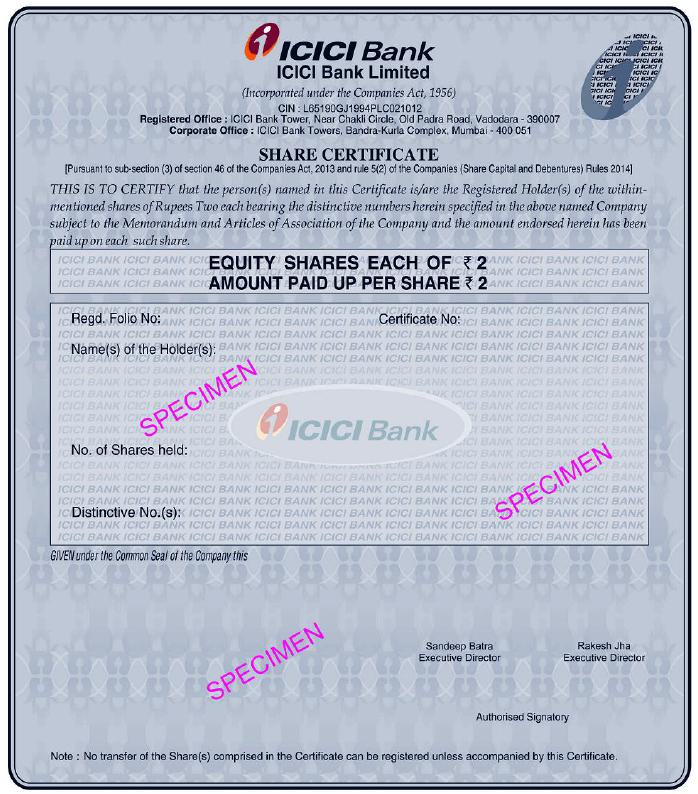

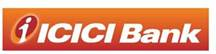

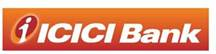

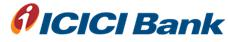

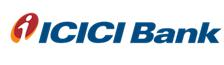

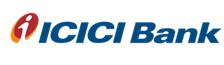

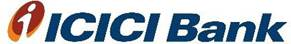

In [58]:
from IPython.display import display, Image

for result in results:
    display(Image(result.download()))

In [24]:
from edgar import *
set_identity("demo@funds.com")

fund_class = find_fund("C000013712")
fund_series = find_fund("S000005029")
fund_inc = find_fund(1083387)

fund_series.fund_classes

[FundClass(Advisor Class A [C000013715] - KINAX),
 FundClass(Advisor Class B [C000013711]),
 FundClass(Advisor Class C [C000013712] - KINCX),
 FundClass(Institutional Class [C000013713]),
 FundClass(No Load Class [C000013714] - WWWFX)]

In [25]:
fund_inc.list_series()

[]

In [27]:
fund_series.get_filings()

╭──────────────────────────────── Filings for KINETICS MUTUAL FUNDS INC [1083387] ────────────────────────────────╮
│                                                                                                                 │
│                                                                              Filing                             │
│    Form        Description                                                   Date         Accession Number      │
│  ─────────────────────────────────────────────────────────────────────────────────────────────────────────────  │
│    N-CSRS      Certified semi-annual shareholder report                      2025-09-02   0001133228-25-0092…   │
│    NPORT-P     Public monthly portfolio investments report                   2025-08-21   0001145549-25-0521…   │
│    NPORT-P     Public monthly portfolio investments report                   2025-08-21   0001145549-25-0521…   │
│    NPORT-P     Public monthly portfolio investments report            

In [29]:
npx_filings = fund_series.get_filings(form="N-PX")
npx_filings

╭──────────────────────────────── Filings for KINETICS MUTUAL FUNDS INC [1083387] ────────────────────────────────╮
│                                                                                                                 │
│                                                                              Filing                             │
│    Form        Description                                                   Date         Accession Number      │
│  ─────────────────────────────────────────────────────────────────────────────────────────────────────────────  │
│    N-PX        Annual proxy voting record report                             2025-08-12   0000894189-25-0055…   │
│    N-PX        Annual proxy voting record report                             2024-08-30   0000894189-24-0052…   │
│    N-PX        Annual proxy voting record report                             2023-08-07   0000894189-23-0054…   │
│    N-PX        Annual proxy voting record report                      

In [32]:


filings = get_filings(form=4).head(10)
filings



╭────────────────────────────────────────────────── SEC Filings ──────────────────────────────────────────────────╮
│                                                                                                                 │
│    Form              CIK   Ticker   Company                                 Filing Date   Accession Number      │
│  ─────────────────────────────────────────────────────────────────────────────────────────────────────────────  │
│    4             1713257            15 Angels II LLC                        2025-09-18    0001193125-25-2076…   │
│    4              910638   DDD      3D SYSTEMS CORP                         2025-09-18    0001629827-25-0000…   │
│    4             1591588   AMRK     A-Mark Precious Metals, Inc.            2025-09-18    0001591588-25-0000…   │
│    4             1084951            ALON ZVI                                2025-09-18    0001213900-25-0892…   │
│    4             1810182   ALXO     ALX ONCOLOGY HOLDINGS INC         

In [35]:
company = Company("VRTX")
company


╭──────────────────────────────────── 🏢 VERTEX PHARMACEUTICALS INC / MA VRTX ────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ ╭───────────────────────────────────────────────── 📋 Entity ─────────────────────────────────────────────────╮ │
│ │                                                                                                             │ │
│ │   CIK   875320   Type   Operating   ○                                                                       │ │
│ │                                                                                                             │ │
│ │                                                                                                             │ │
│ │   Category                  Industry                            Fiscal

In [36]:
initial_filings = (company.get_filings(form=3)
                     .filter(filing_date=':2025-03-04')) # Filter up to this date to keep the notebook data stable
initial_filings

╭───────────────────────────── Filings for VERTEX PHARMACEUTICALS INC / MA [875320] ──────────────────────────────╮
│                                                                                                                 │
│                                                                              Filing                             │
│    Form        Description                                                   Date         Accession Number      │
│  ─────────────────────────────────────────────────────────────────────────────────────────────────────────────  │
│    3           Initial statement of beneficial ownership                     2024-05-17   0000875320-24-0001…   │
│    3           Initial statement of beneficial ownership                     2023-12-06   0000875320-23-0000…   │
│    3           Initial statement of beneficial ownership                     2023-10-10   0001209191-23-0525…   │
│    3           Initial statement of beneficial ownership              

In [37]:
form3 = initial_filings[0].obj()
form3

╭──────────────── Initial Beneficial Ownership ────────────────╮
│ Insider:  Jennifer Schneider                                 │
│ Position: Director                                           │
│ Company:  VERTEX PHARMACEUTICALS INC / MA (VRTX)             │
│ Date:     2024-05-15                                         │
│ Form:     Form 3 (Initial Statement of Beneficial Ownership) │
│ No Securities Beneficially Owned                             │
│ Remarks: Exhibit 24 - Power of Attorney                      │
╰──────────────────────────────────────────────────────────────╯

In [39]:
form3.to_dataframe()

,Date,Form,Issuer,Ticker,Insider,Position,Remarks,Total Shares,Has Derivatives,Holdings
0,2024-05-15,Form 3,VERTEX PHARMACEUTICALS INC / MA,VRTX,Jennifer Schneider,Director,Exhibit 24 - Power of Attorney,0,False,0


In [42]:
form3.to_dataframe(detailed = False)

,Date,Form,Issuer,Ticker,Insider,Position,Remarks,Total Shares,Has Derivatives,Holdings,Common Stock Holdings,Derivative Holdings
0,2024-05-15,Form 3,VERTEX PHARMACEUTICALS INC / MA,VRTX,Jennifer Schneider,Director,Exhibit 24 - Power of Attorney,0,False,0,0,0
